In [1]:
import sys
sys.path.append('../')
sys.path.append('../../')
from CMRx4DFlowMaskGeneration import *
from Utils import *
from einops import rearrange
import matplotlib.pyplot as plt


In [2]:
# Read one subject/case from a directory containing the corresponding .mat files
data_dir = '/mnt/nas/nas3/openData/rawdata/4dFlow/ChallengeData/DemoData'

# `load_mat` takes the .mat file path and variable name (`key`) as input.
# It returns a lazy HDF5-like handle (h5py-style): data is not loaded into memory
# until you index it.
kdata_full = load_mat(data_dir + '/kdata_full.mat', key='kdata_full')
coilmap    = load_mat(data_dir + '/coilmap.mat',    key='coilmap')
segmask    = load_mat(data_dir + '/segmask.mat',    key='segmask')
params     = read_params_csv(data_dir + '/params.csv')

# Use [()] to materialize the entire dataset into RAM as a NumPy array.
kdata_full = kdata_full[()]
coilmap    = coilmap[()]
segmask    = segmask[()]

Nv, Nt, Nc, SPE, PE, FE = kdata_full.shape

VENC = params['VENC']
VOrder = params['venc_order']

In [3]:
img = np.sum(k2i_numpy(kdata_full, ax=[-1, -2, -3]) * np.conj(coilmap), axis=-4)

Mask shape: (1, 12, 1, 39, 160, 1), Actual undersampling rate: 10.00x


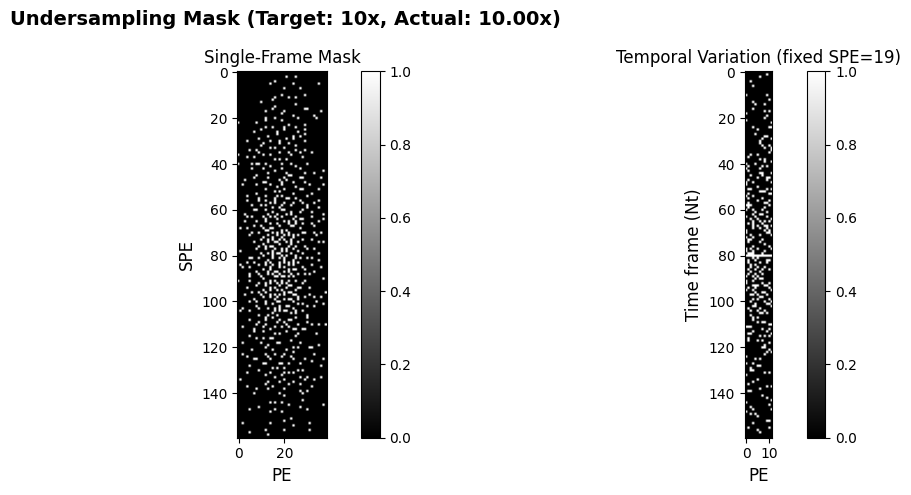

In [4]:
usrate = 10  # Desired undersampling factor (e.g., 10x)

# Target number of sampled k-space locations per 2D (PE, SPE) frame
total_points = PE * SPE // usrate

# fun_mask_gen_2d expects mask_size = (width, height) = (PE, SPE)
mask_size = (PE, SPE)

# Gaussian sampling density parameters:
sigma_x = PE / 5
sigma_y = SPE / 5

# Generate one undersampling mask per time frame.
# Output shape: (SPE, PE, Nt)
masks_spe_pe_t = fun_mask_gen_2d(
    mask_size=mask_size,
    total_points=total_points,
    pattern_num=Nt,
    sigma_x=sigma_x,
    sigma_y=sigma_y,
)

# Reshape to the expected tensor layout:
# (SPE, PE, Nt) -> (1, Nt, 1, SPE, PE, 1)
usmask = rearrange(masks_spe_pe_t, "spe pe t -> 1 t 1 spe pe 1")

# Empirical undersampling factor from the sampling density:
# mean(usmask) is the fraction of sampled points, so 1/mean is the effective acceleration.
actual_usrate = 1.0 / np.mean(usmask)
print(f"Mask shape: {usmask.shape}, Actual undersampling rate: {actual_usrate:.2f}x")

# --- Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(
    f"Undersampling Mask (Target: {usrate}x, Actual: {actual_usrate:.2f}x)",
    fontsize=14,
    fontweight="bold",
)

# Panel 1: a single time-frame mask, displayed as (PE, SPE) for readability
im0 = axes[0].imshow(usmask[0, 0, 0, :, :, 0].T, cmap="gray")
axes[0].set_xlabel("PE", fontsize=12)
axes[0].set_ylabel("SPE", fontsize=12)
axes[0].set_title("Single-Frame Mask", fontsize=12)
plt.colorbar(im0, ax=axes[0], fraction=0.046)

# Panel 2: temporal evolution for a fixed SPE line (middle SPE index).
# Shows (PE vs time) sampling pattern at that SPE location.
im1 = axes[1].imshow(usmask[0, :, 0, SPE // 2, :, 0].T, cmap="gray")
axes[1].set_xlabel("PE", fontsize=12)
axes[1].set_ylabel("Time frame (Nt)", fontsize=12)
axes[1].set_title(f"Temporal Variation (fixed SPE={SPE // 2})", fontsize=12)
plt.colorbar(im1, ax=axes[1], fraction=0.046)

plt.tight_layout()
plt.show()

The image \(X\) can be reconstructed from undersampled multi-coil k-space measurements \(y\) by solving a regularized inverse problem:

$$
\hat{X}
= \arg\min_{X}\;
\frac{1}{2}\bigl\lVert \mathcal{A}(X) - y \bigr\rVert_2^2
\;+\;
\lambda_{\mathrm{llr}} \sum_{i\in\Omega} \bigl\lVert \mathcal{P}_i(X) \bigr\rVert_*
\;+\;
\lambda_{\mathrm{TV}} \,\lVert X \rVert_{\mathrm{TV}}.
$$

**Symbol definitions:**
- $\hat{X}$: The reconstructed image (`img_csllr`).
- $y$: Undersampled multi-coil k-space measurements.
- $\mathcal{A}(\cdot)$: The forward encoding operator that maps an image $X$ to undersampled multi-coil k-space. In this demo, it is the composition of coil sensitivity modulation, FFT, and application of the undersampling mask, i.e.,
  $$
  \mathcal{A}(X) = \mathbf{U}\mathcal{F}\mathbf{C}X,
  $$
  where $\mathbf{C}$ applies the coil sensitivity maps, $\mathcal{F}$ is the FFT, and $\mathbf{U}$ is the undersampling mask.
- $\lambda_{\mathrm{llr}}$: Weight for locally low-rank (LLR) regularization.
- $\Omega$: Index set of local blocks/patches over which LLR is enforced.
- $\mathcal{P}_i(\cdot)$: Patch/block extraction (and reshaping) operator that maps $X$ to the $i$-th local matrix.
- $\lVert \cdot \rVert_*$: Nuclear norm.
- $\lambda_{\mathrm{TV}}$: Weight for total variation (TV) regularization.
- $\lVert X \rVert_{\mathrm{TV}}$: TV seminorm of $X$.

In [5]:
kdata_us = kdata_full * usmask
ksp = rearrange(kdata_us, 'nv nt nc spe pe fe -> nv nc nt fe pe spe')
coils = rearrange(coilmap, 'nc spe pe fe-> nc 1 fe pe spe')
# In this demo, we only use LLR regularization; therefore, we set lamb_tv = 0.0 (i.e., TV regularization is disabled).
lamb_tv = 0.0
lamb_llr = 0.5 
img_csllr = CS_LLR(lamb_tv, lamb_llr, ksp, coils, seg=True, dev='cuda:0')
img_csllr = rearrange(img_csllr, 'nv nt fe pe spe -> nv nt spe pe fe')

/home/caory/miniconda3/envs/ryy/lib/python3.10/site-packages/torch/cuda/memory.py:491: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
/localhome/caory/CMRx4DFlow2026/CMRx4DFlowReconDemo/ForRecon/../Utils/CS_LLR_utils.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bsz = torch.tensor(bsz, dtype=torch.float32)
/localhome/caory/CMRx4DFlow2026/CMRx4DFlowReconDemo/ForRecon/../Utils/CS_LLR_utils.py:148: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(bsz * torch.ceil(imsz / bsz), dtype=torch.long)


it 0 cost=97128.296875 data_cost 73596.765625 nuclear_cost 47063.0546875
	time_data=0.038 time_regs=0.049 time_prox=0.101
it 1 cost=84833.8828125 data_cost 60723.35546875 nuclear_cost 48221.05859375
	time_data=0.004 time_regs=0.001 time_prox=0.101
it 2 cost=74351.671875 data_cost 48820.3984375 nuclear_cost 51062.54296875
	time_data=0.004 time_regs=0.001 time_prox=0.114
it 3 cost=64648.2890625 data_cost 38690.09375 nuclear_cost 51916.390625
	time_data=0.005 time_regs=0.002 time_prox=0.097
it 4 cost=57463.3671875 data_cost 30620.681640625 nuclear_cost 53685.3671875
	time_data=0.004 time_regs=0.001 time_prox=0.104
it 5 cost=52693.984375 data_cost 24418.98046875 nuclear_cost 56550.0078125
	time_data=0.004 time_regs=0.001 time_prox=0.104
it 6 cost=47968.26953125 data_cost 19710.953125 nuclear_cost 56514.6328125
	time_data=0.004 time_regs=0.001 time_prox=0.099
it 7 cost=44362.4375 data_cost 16267.337890625 nuclear_cost 56190.203125
	time_data=0.004 time_regs=0.001 time_prox=0.098
it 8 cost=4

In [6]:
# complex -> (mag, flow)
mag_gt, flow_gt = complex2magflow(img, venc=np.array(VENC))
mag_csllr, flow_csllr = complex2magflow(img_csllr, venc=np.array(VENC))

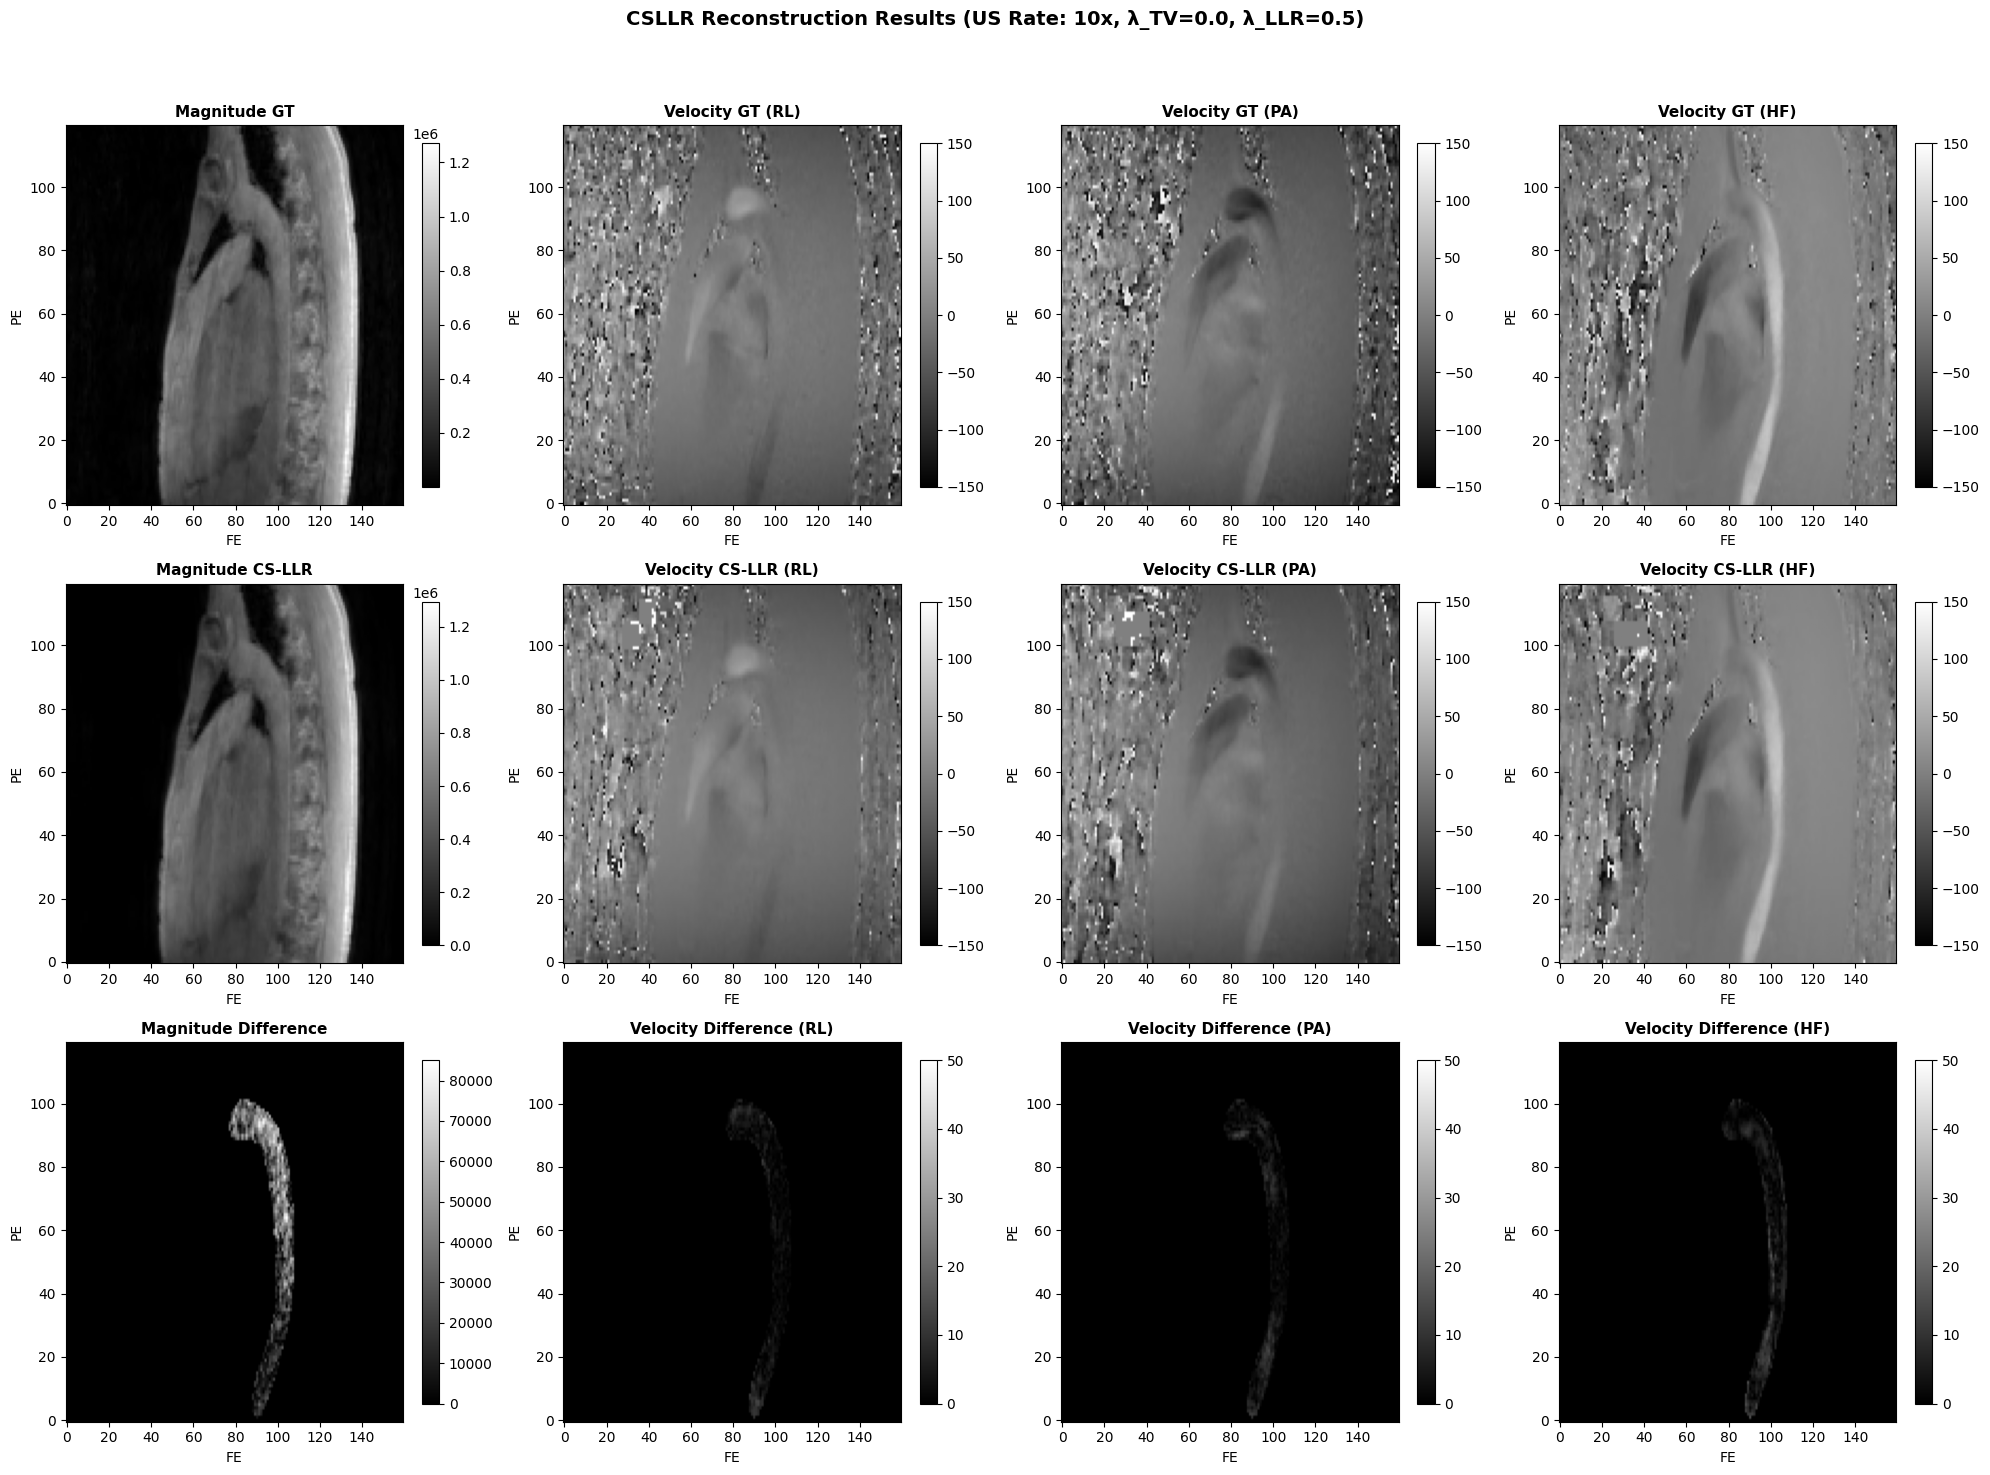

In [7]:
# shapes: (Nv, Nt, SPE, PE, FE)
showz = 14  # SPE index
showt = 1   # Nt index
showv = 0   # magnitude uses this v-index when Nv>1

row, col = 3, 4
fig, axes = plt.subplots(row, col, figsize=(20, 15), constrained_layout=False)
fig.suptitle(
    f"CSLLR Reconstruction Results (US Rate: {usrate}x, λ_TV={lamb_tv}, λ_LLR={lamb_llr})",
    fontsize=14, fontweight="bold"
)

# ---------------- Row 1: GT ----------------
ax = axes[0, 0]
im = ax.imshow(
    np.abs(mag_gt[showv, showt, showz]).T,
    cmap="gray", origin="lower", aspect="auto"
)
ax.set_title("Magnitude GT", fontsize=11, fontweight="bold")
ax.set_xlabel("FE"); ax.set_ylabel("PE")
fig.colorbar(im, ax=ax, fraction=0.046)

for i in range(3):
    ax = axes[0, i + 1]
    img2d = flow_gt[i, showt, showz].T.astype(np.float32)  # no segmask for velocity
    im = ax.imshow(
        img2d,
        cmap="gray", origin="lower", aspect="auto",
        vmin=-VENC[i], vmax=VENC[i]
    )
    ax.set_title(f"Velocity GT ({VOrder[i]})", fontsize=11, fontweight="bold")
    ax.set_xlabel("FE"); ax.set_ylabel("PE")
    fig.colorbar(im, ax=ax, fraction=0.046)

# ---------------- Row 2: CSLLR ----------------
ax = axes[1, 0]
im = ax.imshow(
    np.abs(mag_csllr[showv, showt, showz]).T,
    cmap="gray", origin="lower", aspect="auto"
)
ax.set_title("Magnitude CS-LLR", fontsize=11, fontweight="bold")
ax.set_xlabel("FE"); ax.set_ylabel("PE")
fig.colorbar(im, ax=ax, fraction=0.046)

for i in range(3):
    ax = axes[1, i + 1]
    img2d = flow_csllr[i, showt, showz].T.astype(np.float32)  # no segmask for velocity
    im = ax.imshow(
        img2d,
        cmap="gray", origin="lower", aspect="auto",
        vmin=-VENC[i], vmax=VENC[i]
    )
    ax.set_title(f"Velocity CS-LLR ({VOrder[i]})", fontsize=11, fontweight="bold")
    ax.set_xlabel("FE"); ax.set_ylabel("PE")
    fig.colorbar(im, ax=ax, fraction=0.046)

# ---------------- Row 3: Difference maps ----------------
# Magnitude difference, masked
mag_diff = np.abs(np.abs(mag_csllr) - np.abs(mag_gt))[showv, showt, showz]
ax = axes[2, 0]
im = ax.imshow(
    (mag_diff * segmask[showz]).T,
    cmap="gray", origin="lower", aspect="auto"
)
ax.set_title("Magnitude Difference", fontsize=11, fontweight="bold")
ax.set_xlabel("FE"); ax.set_ylabel("PE")
fig.colorbar(im, ax=ax, fraction=0.046)

# Velocity difference, masked
for i in range(3):
    ax = axes[2, i + 1]
    flow_diff = np.abs(flow_csllr - flow_gt)[i, showt, showz] * segmask[showz]
    im = ax.imshow(
        flow_diff.T.astype(np.float32),
        cmap="gray", origin="lower", aspect="auto",
        vmin=0, vmax=VENC[i] / 3
    )
    ax.set_title(f"Velocity Difference ({VOrder[i]})", fontsize=11, fontweight="bold")
    ax.set_xlabel("FE"); ax.set_ylabel("PE")
    fig.colorbar(im, ax=ax, fraction=0.046)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()